Epoch 1/10
28258/28258 [==============================] - 40s 1ms/step - loss: 0.8771 - accuracy: 0.6238 - val_loss: 0.7879 - val_accuracy: 0.6659
Epoch 2/10
28258/28258 [==============================] - 37s 1ms/step - loss: 0.8223 - accuracy: 0.6547 - val_loss: 0.7743 - val_accuracy: 0.6794
Epoch 3/10
28258/28258 [==============================] - 39s 1ms/step - loss: 0.8090 - accuracy: 0.6603 - val_loss: 0.7695 - val_accuracy: 0.6838
Epoch 4/10
28258/28258 [==============================] - 36s 1ms/step - loss: 0.8008 - accuracy: 0.6638 - val_loss: 0.7522 - val_accuracy: 0.6845
Epoch 5/10
28258/28258 [==============================] - 38s 1ms/step - loss: 0.7954 - accuracy: 0.6674 - val_loss: 0.7514 - val_accuracy: 0.6869
Epoch 6/10
28258/28258 [==============================] - 36s 1ms/step - loss: 0.7916 - accuracy: 0.6691 - val_loss: 0.7506 - val_accuracy: 0.6938
Epoch 7/10
28258/28258 [==============================] - 38s 1ms/step - loss: 0.7890 - accuracy: 0.6701 - val_loss: 0

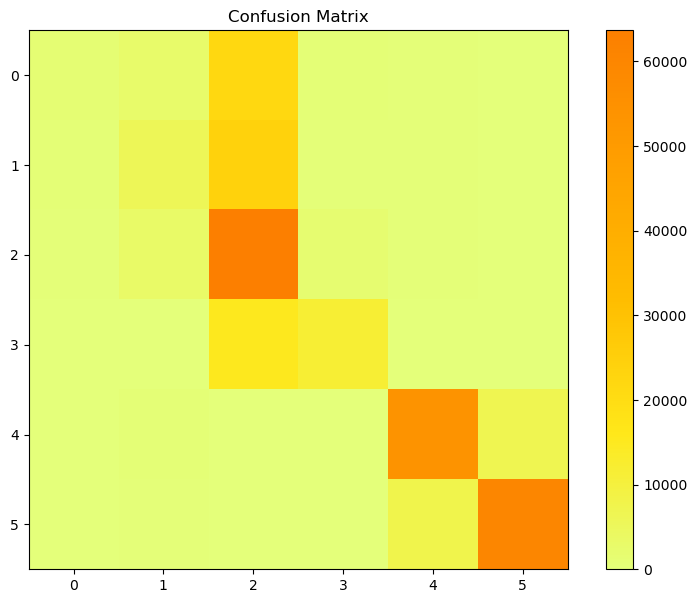

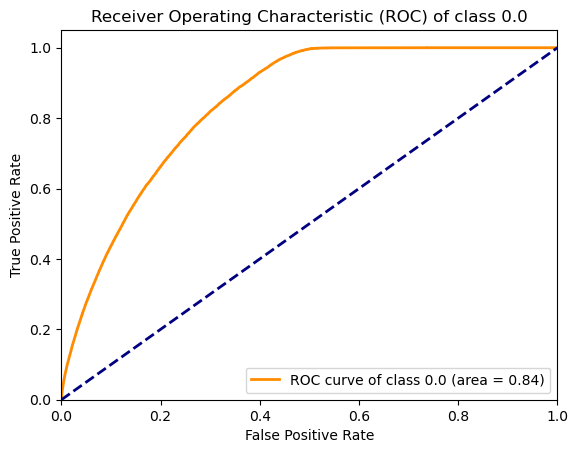

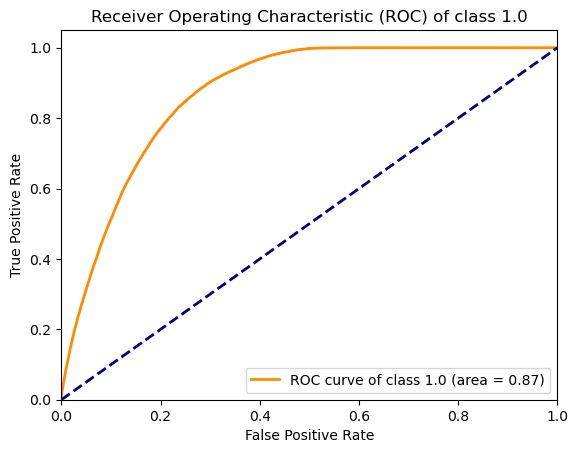

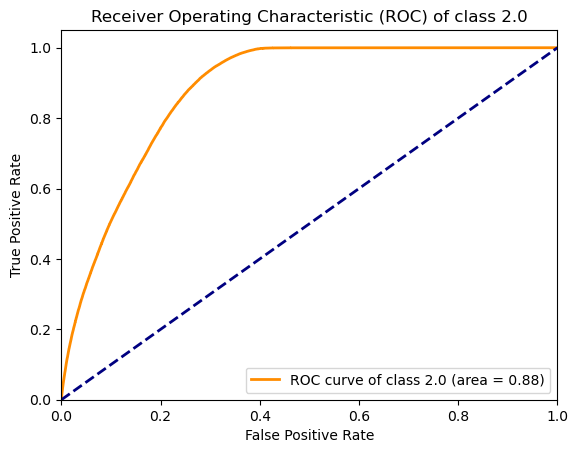

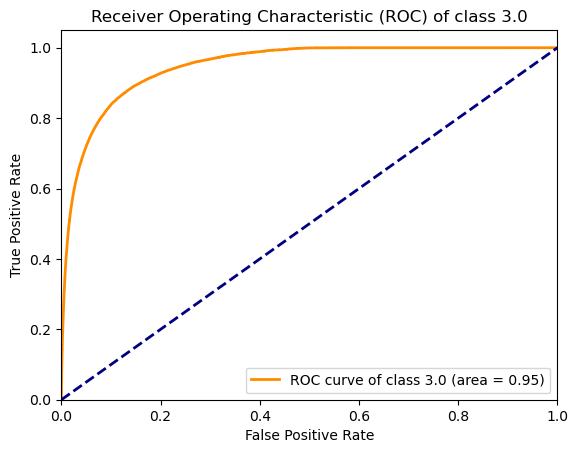

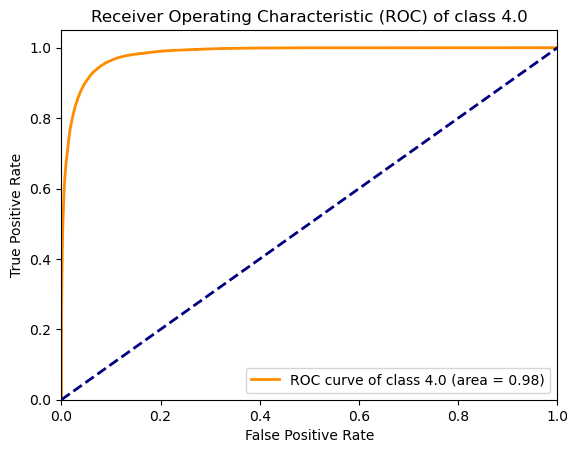

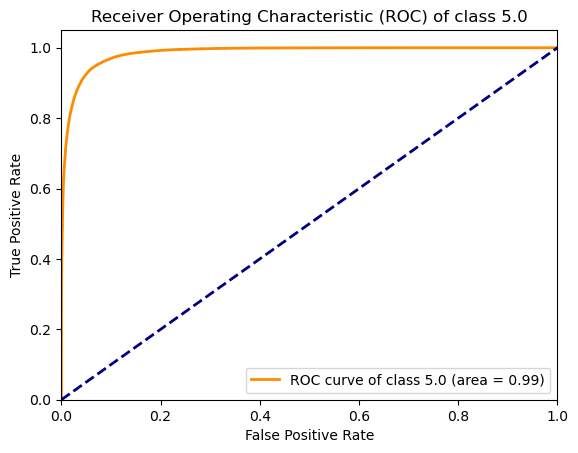

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model_v2/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model_v2/assets


In [27]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os


def train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                     preprocess='standard', test_size=0.2, random_state=None, 
                     epochs=10, batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Prepare features and labels
    X = dataset.drop(columns=[target]).values
    y = pd.get_dummies(dataset[target]).values if task == 'multi_class' else dataset[target].apply(lambda x: 1 if x == positive_label else 0).values
    
    # Preprocess
    if preprocess == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    elif preprocess == 'normal':
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # Build Model
    inp = tf.keras.Input(shape=(X_train.shape[1], 1))
    conv_1 = tf.keras.layers.Conv1D(50, kernel_size=2, padding='same', activation='relu')(inp)
    pool_1 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_1)
    drop_1 = tf.keras.layers.Dropout(0.25)(pool_1)
    
    conv_2 = tf.keras.layers.Conv1D(40, kernel_size=2, padding='same', activation='relu')(drop_1)
    pool_2 = tf.keras.layers.MaxPooling1D(pool_size=2)(conv_2)
    drop_2 = tf.keras.layers.Dropout(0.25)(pool_2)
    
    conv_3 = tf.keras.layers.Conv1D(20, kernel_size=2, padding='same', activation='relu')(drop_2)
    drop_3 = tf.keras.layers.Dropout(0.25)(conv_3)
    
    flat = tf.keras.layers.Flatten()(drop_3)
    hidden = tf.keras.layers.Dense(400, activation='relu')(flat)
    drop_4 = tf.keras.layers.Dropout(0.5)(hidden)
    
    out = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(drop_4)

    model = tf.keras.Model(inputs=inp, outputs=out) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

    # Plot ROC curve for each class
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model_v2'))

    return acc, conf_mat, class_report

# The function has been modified. Please note that the actual improvement in accuracy can only be verified by running the function with appropriate data.

file_path = 'clean.csv'
results = train_eval_model(file_path, target='act',
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)


Epoch 1/10
28258/28258 [==============================] - 80s 3ms/step - loss: 0.8705 - accuracy: 0.6250 - val_loss: 0.7507 - val_accuracy: 0.6885
Epoch 2/10
28258/28258 [==============================] - 92s 3ms/step - loss: 0.8096 - accuracy: 0.6601 - val_loss: 0.7207 - val_accuracy: 0.7025
Epoch 3/10
28258/28258 [==============================] - 92s 3ms/step - loss: 0.7916 - accuracy: 0.6696 - val_loss: 0.7193 - val_accuracy: 0.7088
Epoch 4/10
28258/28258 [==============================] - 72s 3ms/step - loss: 0.7808 - accuracy: 0.6747 - val_loss: 0.7177 - val_accuracy: 0.7070
Epoch 5/10
28258/28258 [==============================] - 75s 3ms/step - loss: 0.7729 - accuracy: 0.6792 - val_loss: 0.7043 - val_accuracy: 0.7150
Epoch 6/10
28258/28258 [==============================] - 70s 2ms/step - loss: 0.7671 - accuracy: 0.6822 - val_loss: 0.7189 - val_accuracy: 0.7108
Epoch 7/10
28258/28258 [==============================] - 70s 2ms/step - loss: 0.7640 - accuracy: 0.6833 - val_loss: 0

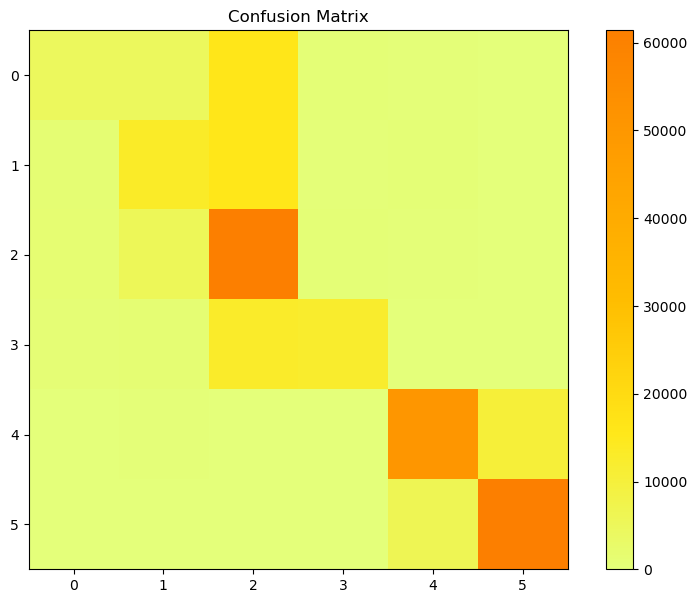

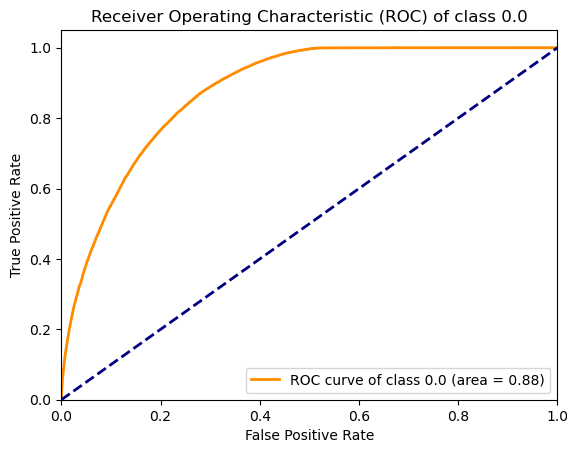

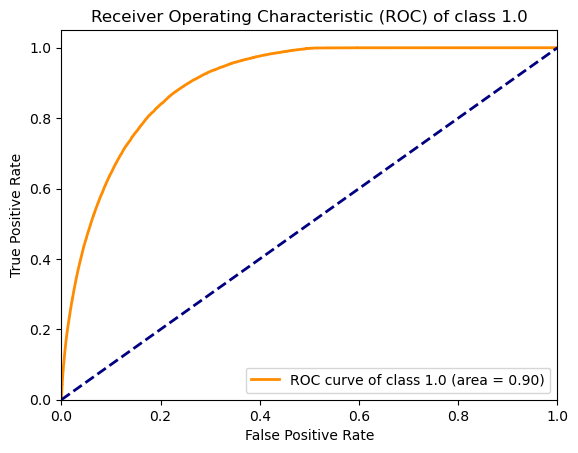

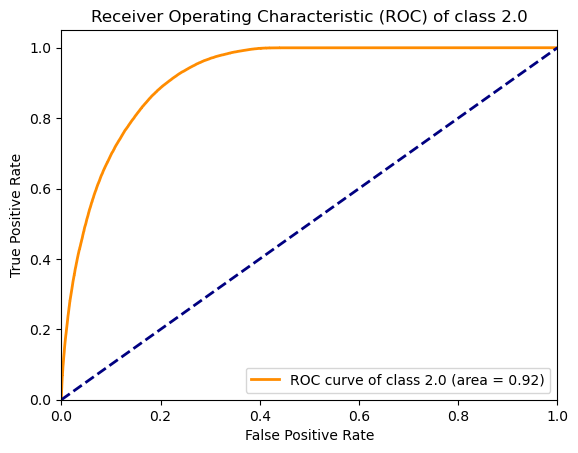

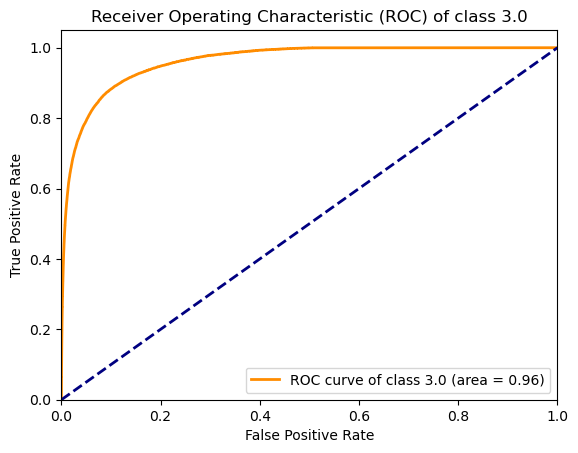

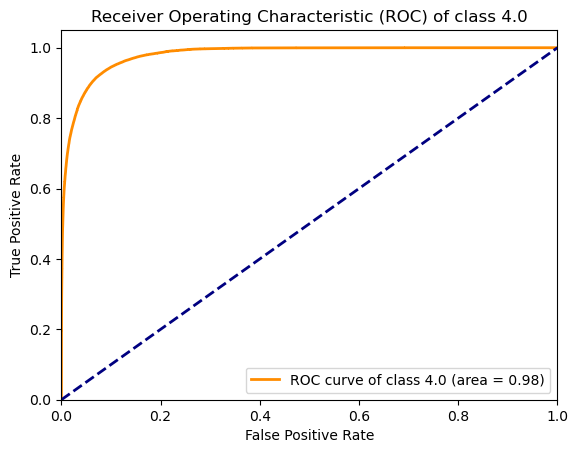

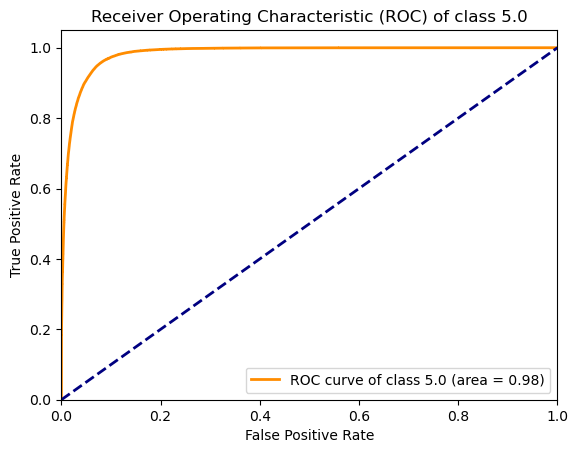

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model_v2/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model_v2/assets


In [28]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def train_eval_model_v2(file_path, target='act', preprocess='standard', 
                                  test_size=0.2, random_state=None, epochs=50, batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Prepare features and labels
    X = dataset.drop(columns=[target]).values
    y = pd.get_dummies(dataset[target]).values  # One-hot encoding for multi-class classification
    
    # Preprocess
    if preprocess == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    elif preprocess == 'normal':
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # Build Model
    inp = tf.keras.Input(shape=(X_train.shape[1], 1))
    x = tf.keras.layers.BatchNormalization()(inp)
    
    x = tf.keras.layers.Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    flat = tf.keras.layers.Flatten()(x)
    hidden = tf.keras.layers.Dense(512, activation='relu')(flat)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    drop = tf.keras.layers.Dropout(0.5)(hidden)
    
    out = tf.keras.layers.Dense(y_train.shape[1], activation='softmax')(drop)

    model = tf.keras.Model(inputs=inp, outputs=out) 
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    # Implementing Early Stopping
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # Train
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[early_stop])
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)
    
    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

    # Plot ROC curve for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(y_train.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    for i, label in enumerate(dataset[target].unique()):
        plt.figure()
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model_v2'))

    return acc, conf_mat, class_report

# To use the function:
# file_path = 'clean.csv'
# results = optimized_train_eval_model_v2(file_path)

file_path = 'clean.csv'
results = train_eval_model_v2(file_path, target='act',
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)


Epoch 1/10
28258/28258 [==============================] - 30s 1ms/step - loss: 0.7769 - accuracy: 0.6729 - val_loss: 0.6885 - val_accuracy: 0.7161
Epoch 2/10
28258/28258 [==============================] - 30s 1ms/step - loss: 0.6939 - accuracy: 0.7160 - val_loss: 0.6484 - val_accuracy: 0.7392
Epoch 3/10
28258/28258 [==============================] - 33s 1ms/step - loss: 0.6709 - accuracy: 0.7274 - val_loss: 0.6377 - val_accuracy: 0.7446
Epoch 4/10
28258/28258 [==============================] - 30s 1ms/step - loss: 0.6575 - accuracy: 0.7338 - val_loss: 0.6295 - val_accuracy: 0.7469
Epoch 5/10
28258/28258 [==============================] - 30s 1ms/step - loss: 0.6494 - accuracy: 0.7375 - val_loss: 0.6162 - val_accuracy: 0.7558
Epoch 6/10
28258/28258 [==============================] - 30s 1ms/step - loss: 0.6433 - accuracy: 0.7405 - val_loss: 0.6119 - val_accuracy: 0.7558
Epoch 7/10
28258/28258 [==============================] - 31s 1ms/step - loss: 0.6381 - accuracy: 0.7434 - val_loss: 0

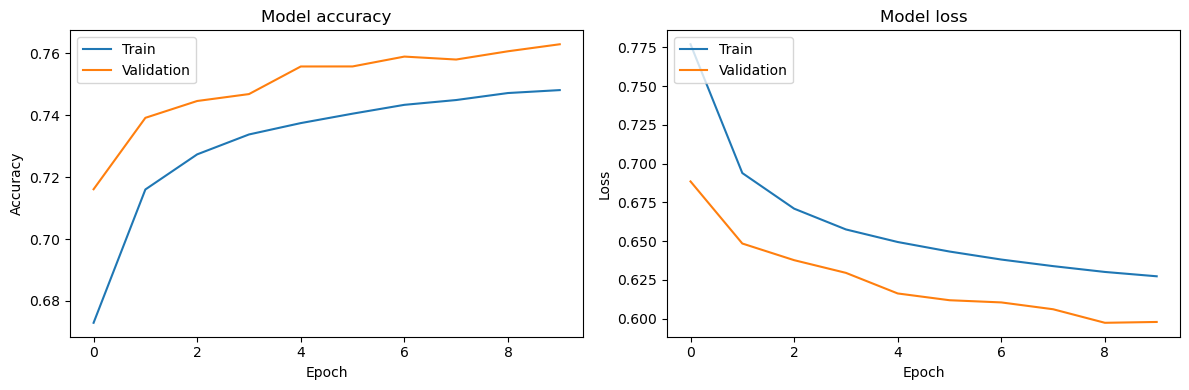

8831/8831 [==============================] - 4s 397us/step
Accuracy: 0.7628400448733602
Confusion Matrix: 
[[ 7614  3017 13549  1937   261    31]
 [ 2866 11520 15225  1220   354    71]
 [ 2851  3215 60478  2185   261    27]
 [  965   716  6641 18592    14     4]
 [  166   224    97     1 56282  4480]
 [   78   147    89     0  6323 61072]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.52      0.29      0.37     26409
           1       0.61      0.37      0.46     31256
           2       0.63      0.88      0.73     69017
           3       0.78      0.69      0.73     26932
           4       0.89      0.92      0.90     61250
           5       0.93      0.90      0.92     67709

    accuracy                           0.76    282573
   macro avg       0.73      0.67      0.69    282573
weighted avg       0.76      0.76      0.75    282573



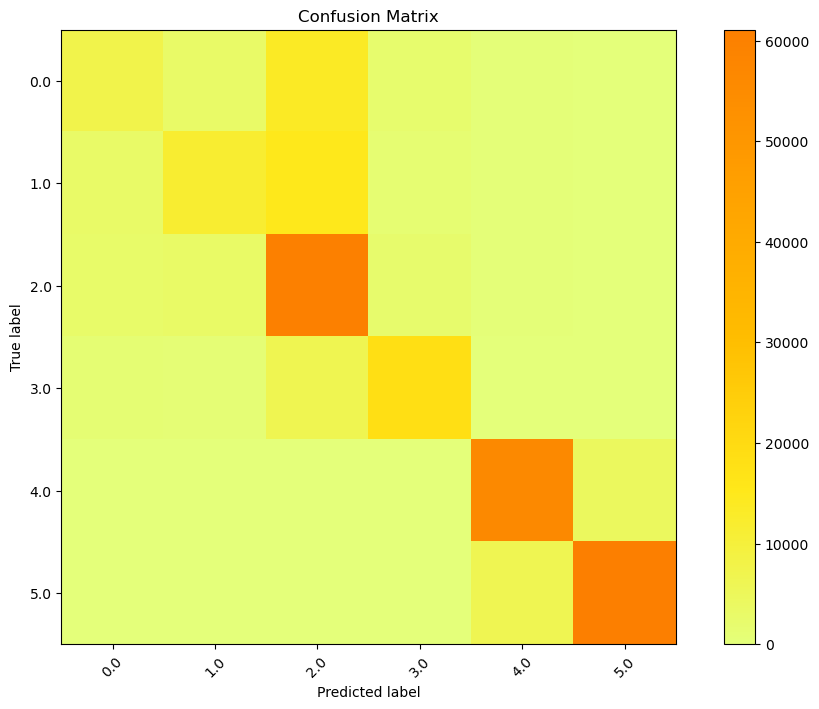

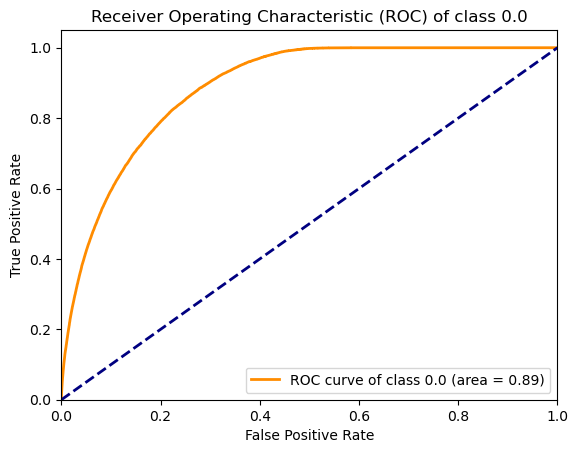

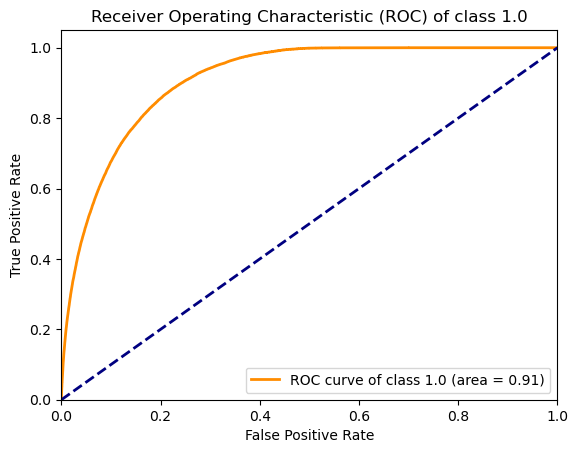

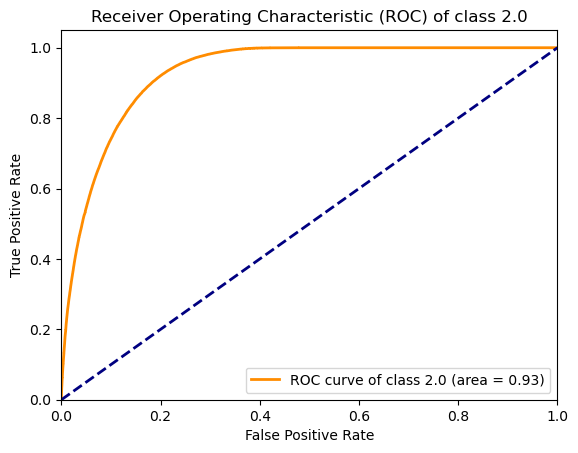

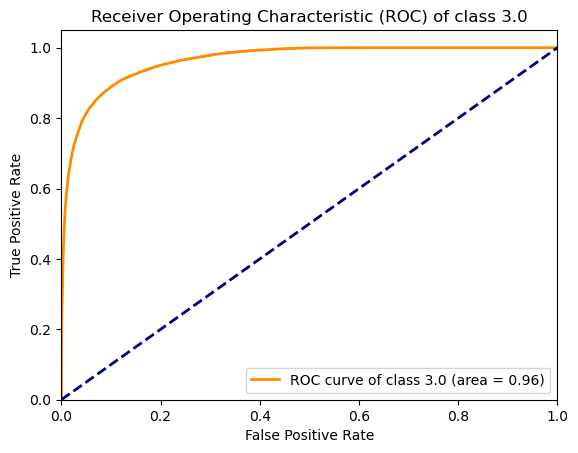

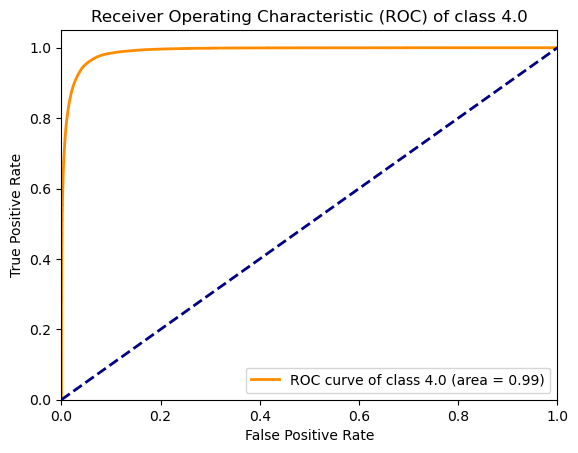

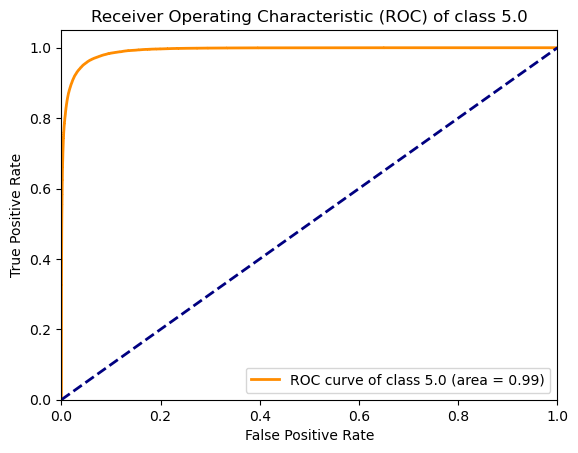

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def train_eval_model_v3(file_path, target='act', task='multi_class', positive_label=None,
                     preprocess='standard', test_size=0.2, random_state=None, 
                     epochs=10, batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Prepare features and labels
    X = dataset.drop(columns=[target]).values
    y = pd.get_dummies(dataset[target]).values if task == 'multi_class' else dataset[target].apply(lambda x: 1 if x == positive_label else 0).values
    
    # Preprocess
    if preprocess == 'standard':
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    elif preprocess == 'normal':
        scaler = MinMaxScaler()
        X = scaler.fit_transform(X)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = np.expand_dims(X_train, axis=2)
    X_test = np.expand_dims(X_test, axis=2)

    # Build Model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(128, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    # Plot training & validation accuracy and loss values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset[target].unique()))
    plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
    plt.yticks(tick_marks, dataset[target].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = train_eval_model_v3(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)


Epoch 1/10
442/442 [==============================] - 3s 6ms/step - loss: 0.8637 - accuracy: 0.6915 - val_loss: 0.4239 - val_accuracy: 0.8616
Epoch 2/10
442/442 [==============================] - 3s 6ms/step - loss: 0.3190 - accuracy: 0.8984 - val_loss: 0.2966 - val_accuracy: 0.9026
Epoch 3/10
442/442 [==============================] - 3s 7ms/step - loss: 0.2057 - accuracy: 0.9388 - val_loss: 0.3184 - val_accuracy: 0.8984
Epoch 4/10
442/442 [==============================] - 3s 8ms/step - loss: 0.1466 - accuracy: 0.9545 - val_loss: 0.2484 - val_accuracy: 0.9230
Epoch 5/10
442/442 [==============================] - 3s 8ms/step - loss: 0.1022 - accuracy: 0.9692 - val_loss: 0.2673 - val_accuracy: 0.9210
Epoch 6/10
442/442 [==============================] - 3s 8ms/step - loss: 0.0746 - accuracy: 0.9769 - val_loss: 0.2597 - val_accuracy: 0.9272
Epoch 7/10
442/442 [==============================] - 3s 8ms/step - loss: 0.0539 - accuracy: 0.9835 - val_loss: 0.2481 - val_accuracy: 0.9357
Epoch 

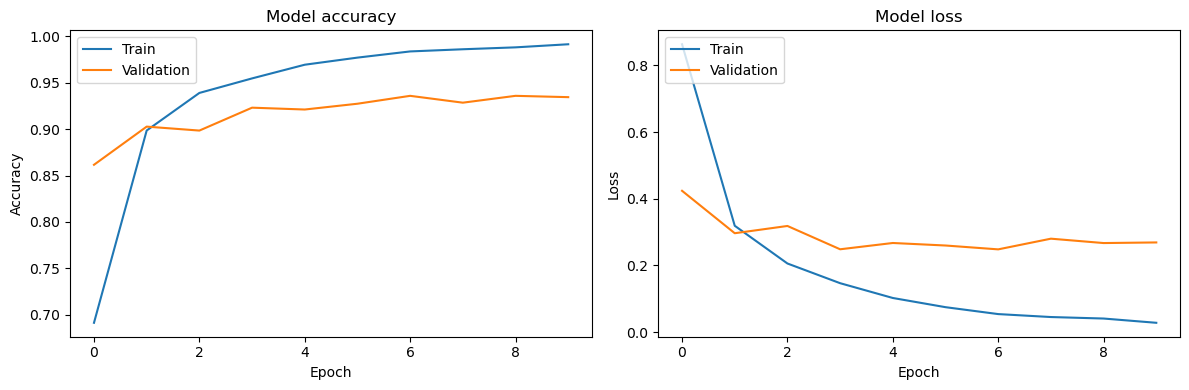

138/138 [==============================] - 0s 3ms/step
Accuracy: 0.932955832389581
Confusion Matrix: 
[[ 344   19   33   18    5    5]
 [  19  427   25    1    9    2]
 [   9   11 1059    2    4    0]
 [  12    3    1  420    0    1]
 [   1    7    5    2  850   38]
 [   6    3    0    5   50 1019]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       424
           1       0.91      0.88      0.90       483
           2       0.94      0.98      0.96      1085
           3       0.94      0.96      0.95       437
           4       0.93      0.94      0.93       903
           5       0.96      0.94      0.95      1083

    accuracy                           0.93      4415
   macro avg       0.93      0.92      0.92      4415
weighted avg       0.93      0.93      0.93      4415



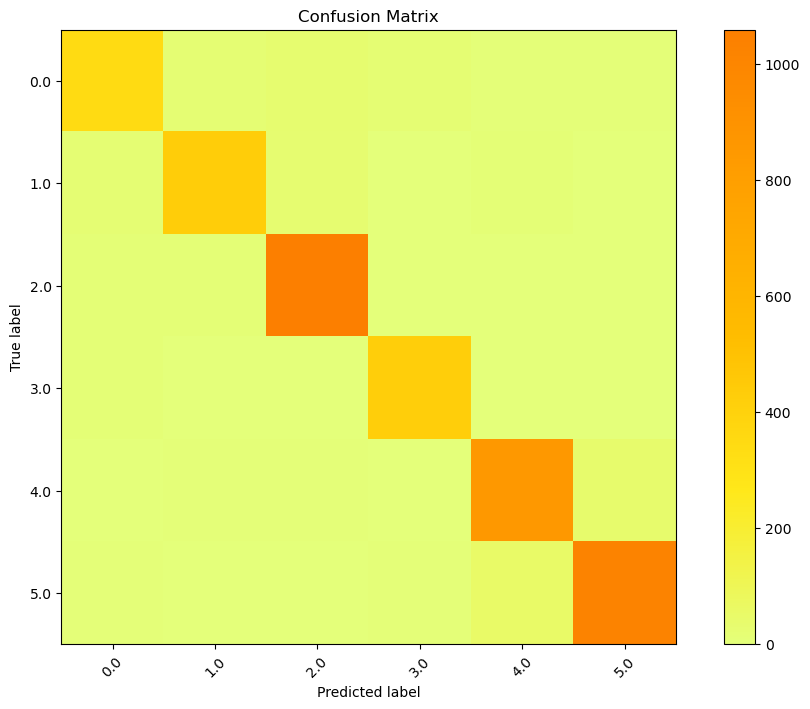

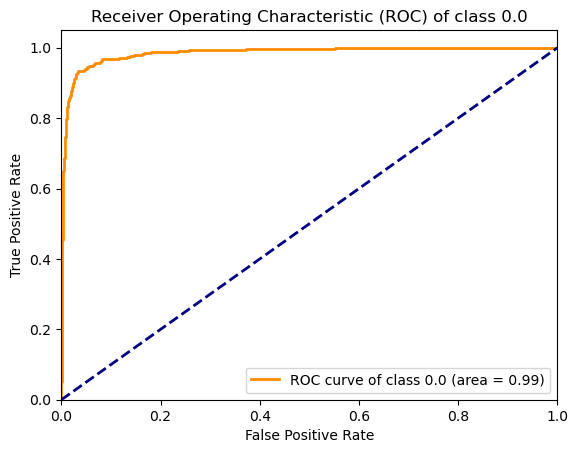

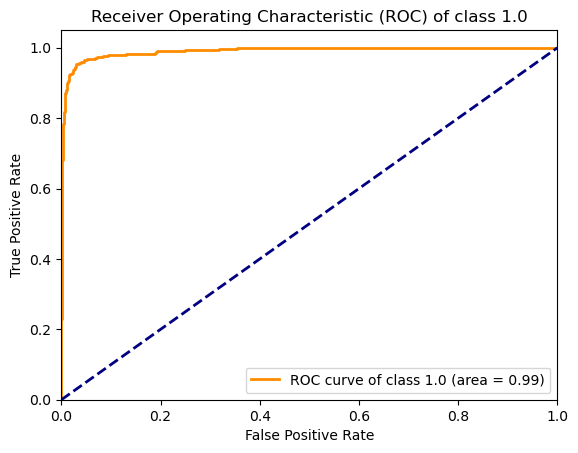

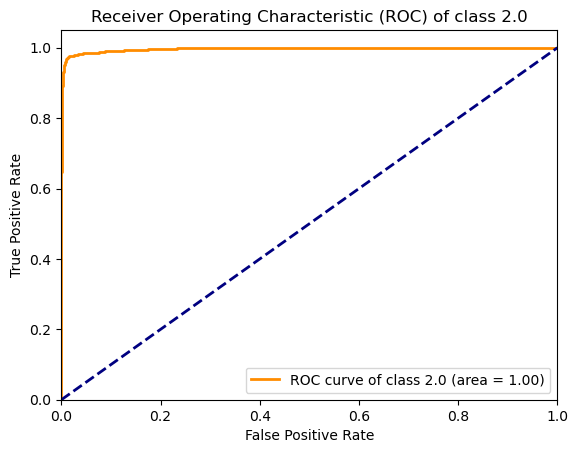

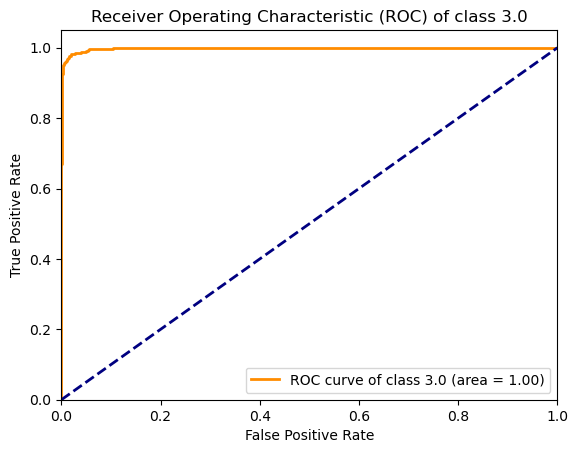

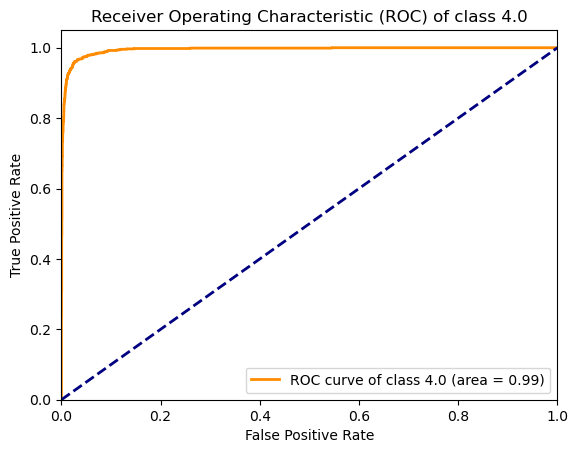

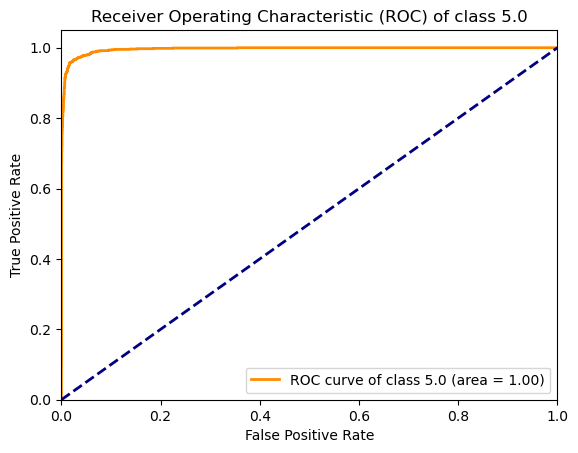

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def train_eval_model_v4(file_path, window_size=128, step_size=64, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Convert to windows
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]  # Convert labels to integers
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    # Preprocess
    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)  # Add a channel dimension
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Build Model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset[target].unique()))
    plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
    plt.yticks(tick_marks, dataset[target].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = train_eval_model_v4(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)


Epoch 1/10
28257/28257 [==============================] - 104s 4ms/step - loss: 0.2337 - accuracy: 0.9273 - val_loss: 0.1382 - val_accuracy: 0.9593
Epoch 2/10
28257/28257 [==============================] - 97s 3ms/step - loss: 0.1414 - accuracy: 0.9563 - val_loss: 0.1151 - val_accuracy: 0.9645
Epoch 3/10
28257/28257 [==============================] - 99s 4ms/step - loss: 0.1185 - accuracy: 0.9623 - val_loss: 0.1063 - val_accuracy: 0.9671
Epoch 4/10
28257/28257 [==============================] - 101s 4ms/step - loss: 0.1056 - accuracy: 0.9660 - val_loss: 0.0967 - val_accuracy: 0.9693
Epoch 5/10
28257/28257 [==============================] - 100s 4ms/step - loss: 0.0952 - accuracy: 0.9691 - val_loss: 0.0898 - val_accuracy: 0.9720
Epoch 6/10
28257/28257 [==============================] - 102s 4ms/step - loss: 0.0875 - accuracy: 0.9710 - val_loss: 0.0856 - val_accuracy: 0.9732
Epoch 7/10
28257/28257 [==============================] - 101s 4ms/step - loss: 0.0821 - accuracy: 0.9726 - val_lo

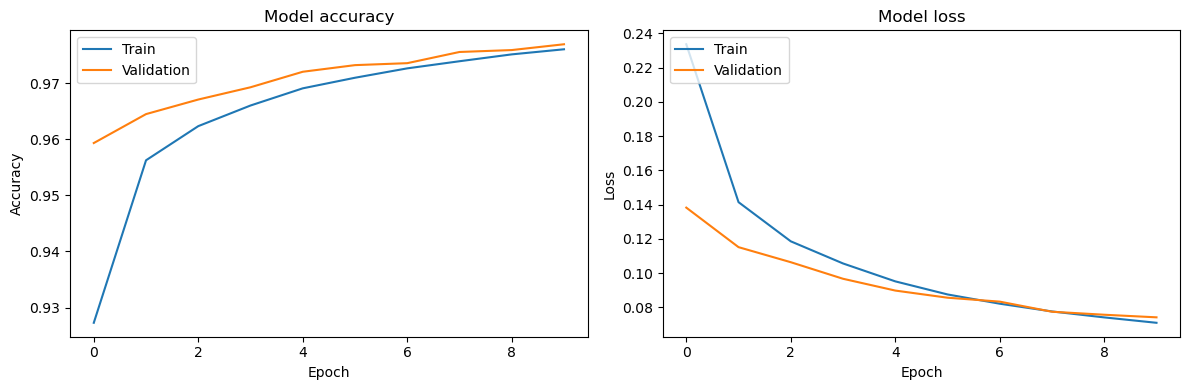

8831/8831 [==============================] - 7s 794us/step
Accuracy: 0.9769715887374187
Confusion Matrix: 
[[24970   451   762    37    89    80]
 [  488 29907   758    26   122    79]
 [  224   293 68220    23   120    14]
 [  144    86   104 26312    28    40]
 [   81    41    37    18 60041  1179]
 [   56    40    21     6  1060 66607]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     26389
           1       0.97      0.95      0.96     31380
           2       0.98      0.99      0.98     68894
           3       1.00      0.98      0.99     26714
           4       0.98      0.98      0.98     61397
           5       0.98      0.98      0.98     67790

    accuracy                           0.98    282564
   macro avg       0.98      0.97      0.97    282564
weighted avg       0.98      0.98      0.98    282564



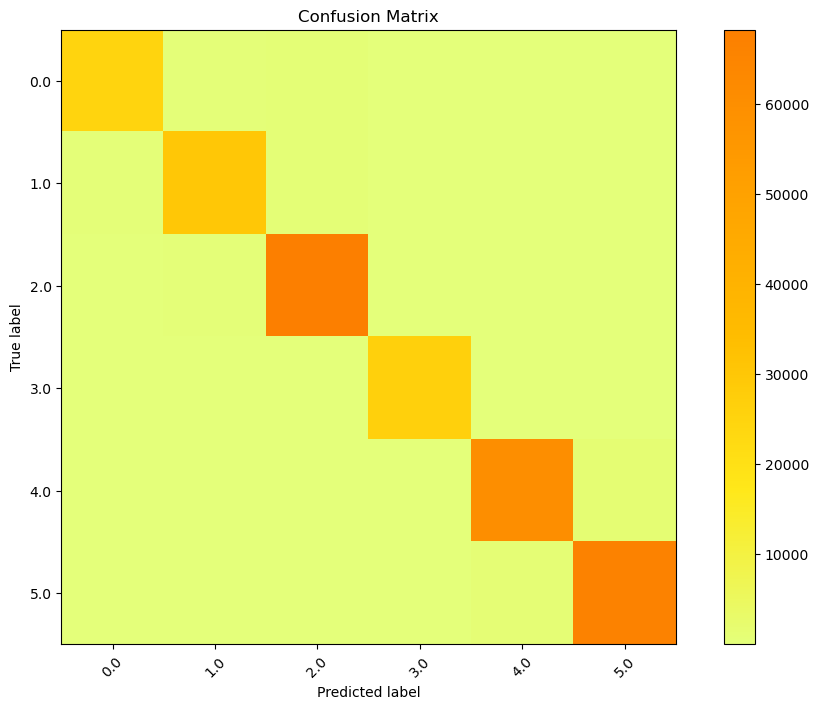

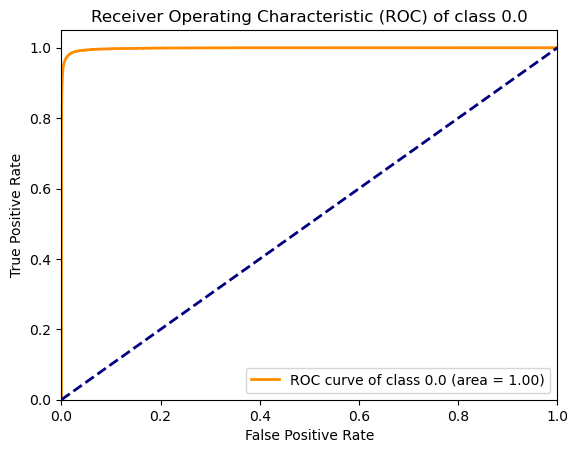

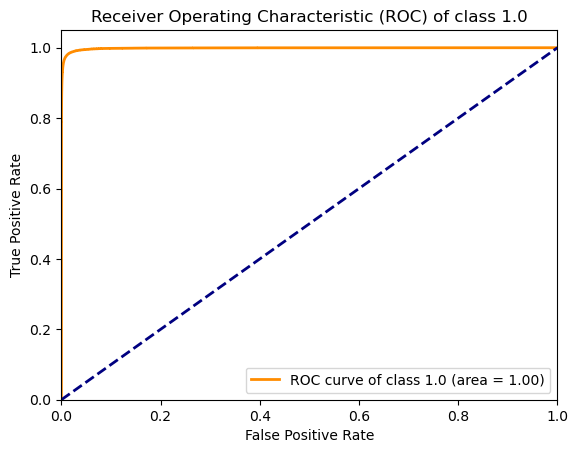

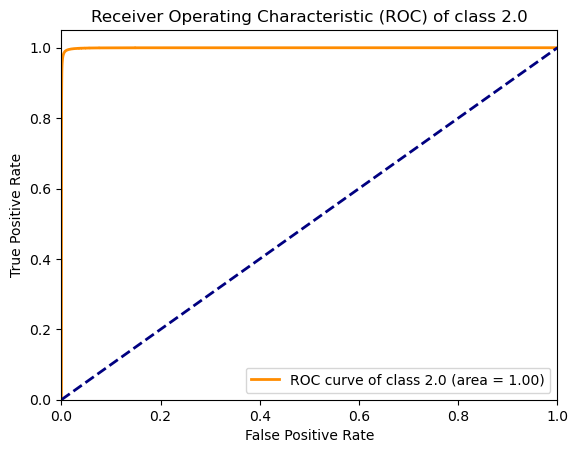

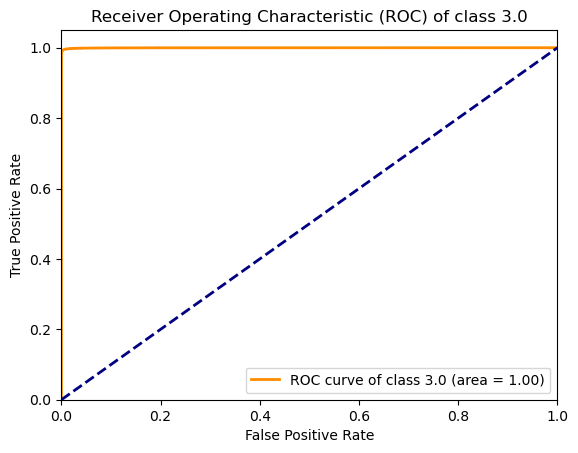

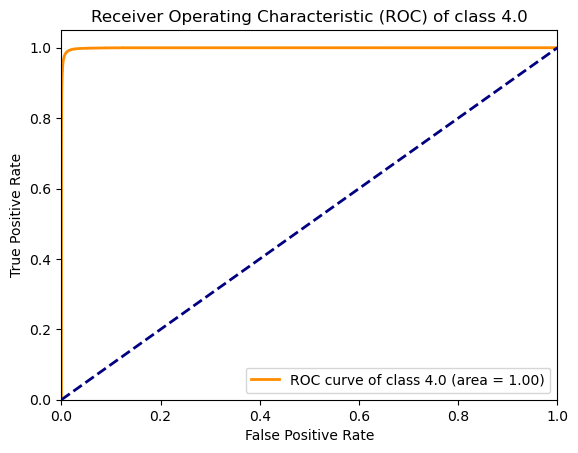

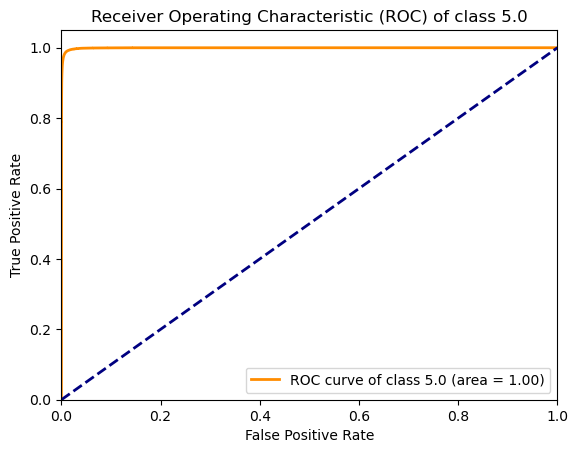

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    """
    Create windows from a data matrix.
    data: The input data. The last column is assumed to be the label if with_label is True.
    window_size: The size of the sliding window.
    step_size: The step size of the sliding window.
    with_label: Whether the data contains a label column.
    """
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            # Take the mode (most common) label in the window as the label for this window
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def train_eval_model_v5(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):

    # Load Data
    dataset = pd.read_csv(file_path)
    
    # Convert to windows
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]  # Convert labels to integers
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    # Preprocess
    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)  # Add a channel dimension
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Build Model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    
    # Train
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    # Evaluate
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Evaluate again
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)

    print(f"Accuracy: {acc}")
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 7))
    plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Wistia)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(dataset[target].unique()))
    plt.xticks(tick_marks, dataset[target].unique(), rotation=45)
    plt.yticks(tick_marks, dataset[target].unique())
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        for i, label in enumerate(dataset[target].unique()):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Save Model
    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = train_eval_model_v5(file_path, target='act', task='multi_class', positive_label=None,
                 preprocess='standard', test_size=0.2, 
                 random_state=42, epochs=10, batch_size=32, 
                 save_model=True)


Epoch 1/10
28257/28257 [==============================] - 80s 3ms/step - loss: 0.2346 - accuracy: 0.9274 - val_loss: 0.1369 - val_accuracy: 0.9585
Epoch 2/10
28257/28257 [==============================] - 79s 3ms/step - loss: 0.1417 - accuracy: 0.9563 - val_loss: 0.1162 - val_accuracy: 0.9639
Epoch 3/10
28257/28257 [==============================] - 84s 3ms/step - loss: 0.1180 - accuracy: 0.9628 - val_loss: 0.1009 - val_accuracy: 0.9684
Epoch 4/10
28257/28257 [==============================] - 87s 3ms/step - loss: 0.1046 - accuracy: 0.9661 - val_loss: 0.0982 - val_accuracy: 0.9688
Epoch 5/10
28257/28257 [==============================] - 77s 3ms/step - loss: 0.0947 - accuracy: 0.9690 - val_loss: 0.0891 - val_accuracy: 0.9718
Epoch 6/10
28257/28257 [==============================] - 82s 3ms/step - loss: 0.0876 - accuracy: 0.9708 - val_loss: 0.0828 - val_accuracy: 0.9730
Epoch 7/10
28257/28257 [==============================] - 83s 3ms/step - loss: 0.0821 - accuracy: 0.9726 - val_loss: 0

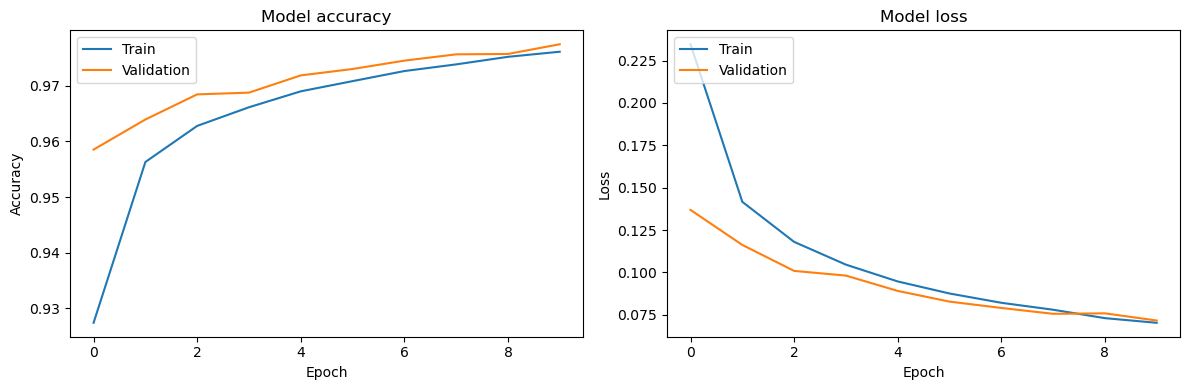

35321/35321 [==============================] - 23s 662us/step


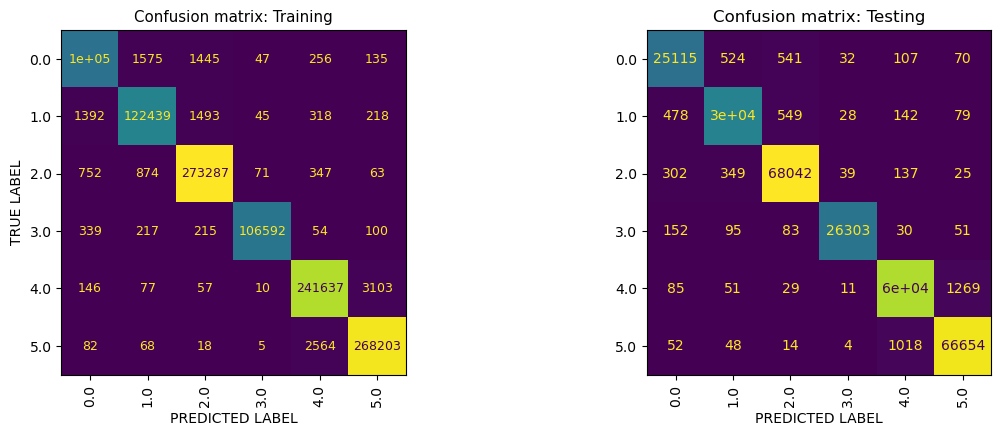

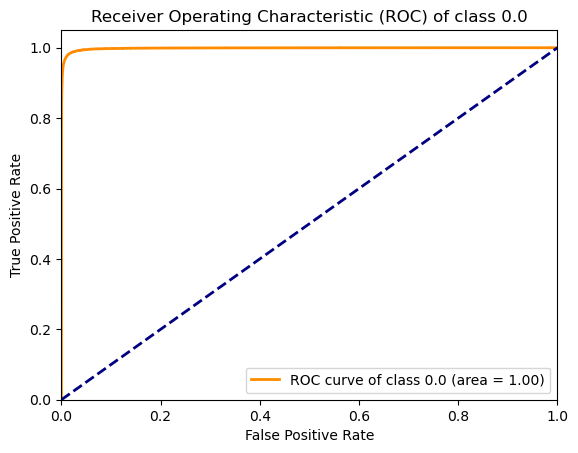

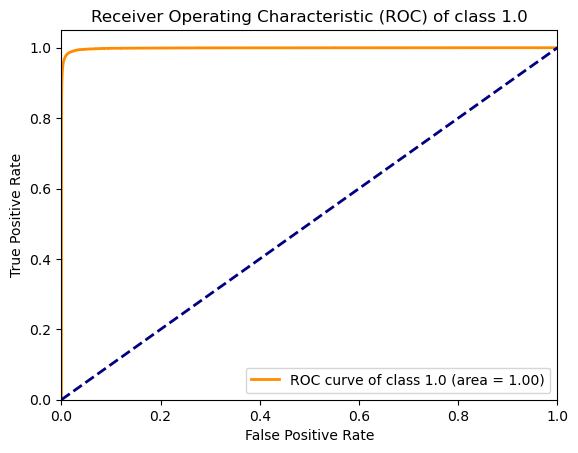

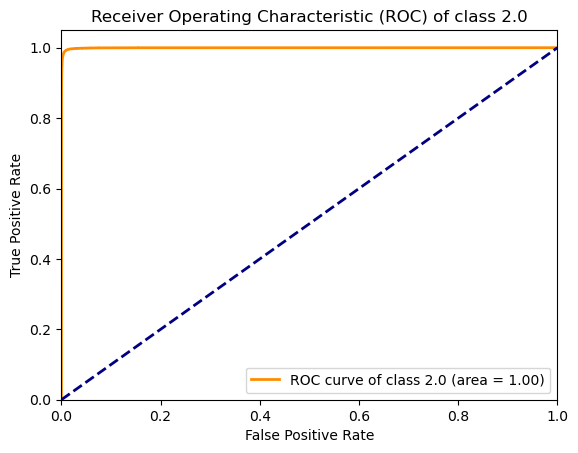

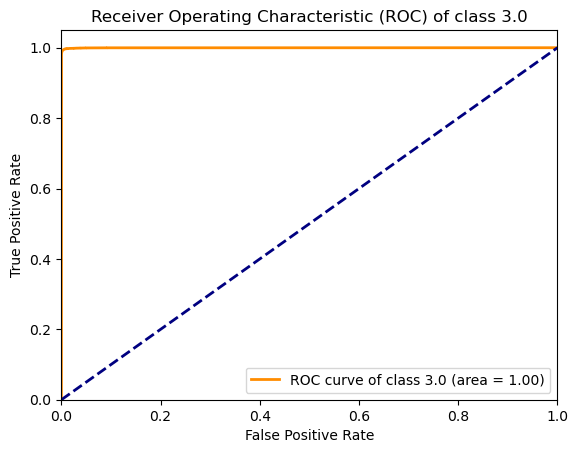

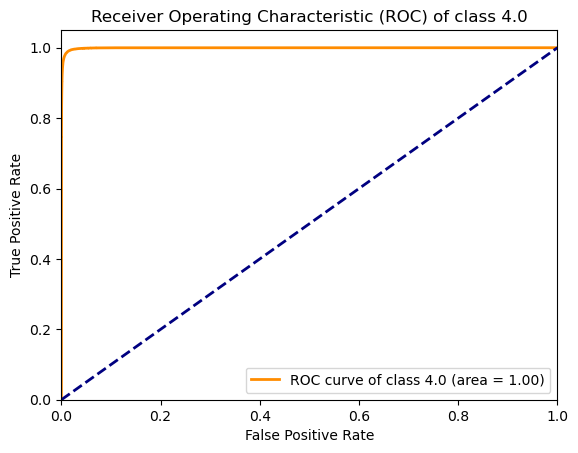

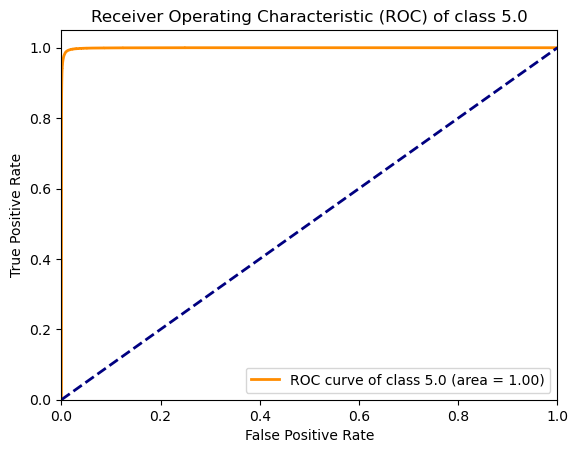

Accuracy: 0.9773714981384748
Confusion Matrix: 
[[25115   524   541    32   107    70]
 [  478 30104   549    28   142    79]
 [  302   349 68042    39   137    25]
 [  152    95    83 26303    30    51]
 [   85    51    29    11 59952  1269]
 [   52    48    14     4  1018 66654]]
Classification Report: 
              precision    recall  f1-score   support

           0       0.96      0.95      0.96     26389
           1       0.97      0.96      0.96     31380
           2       0.98      0.99      0.99     68894
           3       1.00      0.98      0.99     26714
           4       0.98      0.98      0.98     61397
           5       0.98      0.98      0.98     67790

    accuracy                           0.98    282564
   macro avg       0.98      0.97      0.98    282564
weighted avg       0.98      0.98      0.98    282564

INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


INFO:tensorflow:Assets written to: /Users/yongyiyang/Desktop/Capstone/script/cnn_model/assets


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import os

def create_windows(data, window_size, step_size=1, with_label=True):
    windows, labels = [], []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data[i:i + window_size, :-1]
        windows.append(window)
        if with_label:
            label = np.bincount(data[i:i + window_size, -1].astype(int)).argmax()
            labels.append(label)
    return np.array(windows), np.array(labels)

def plot_cm(y_train, y_train_pred, y_test, y_test_pred, labels):
    y_train = np.argmax(y_train, axis=-1)
    y_test = np.argmax(y_test, axis=-1)

    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    plt.subplots_adjust(wspace=0.7)
    plt.rc('font', size=9)
    cm_train = ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, ax=axs[0], display_labels=labels)
    axs[0].set_title("Confusion matrix: Training")
    axs[0].set_xticklabels(labels, rotation=90)
    cm_train.im_.colorbar.remove()
    axs[0].set_ylabel('TRUE LABEL')
    axs[0].set_xlabel('PREDICTED LABEL')
    
    plt.rc('font', size=10)
    cm_test = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axs[1], display_labels=labels)
    axs[1].set_title("Confusion matrix: Testing")
    axs[1].set_xticklabels(labels, rotation=90)
    cm_test.im_.colorbar.remove()
    axs[1].set_ylabel('')
    axs[1].set_xlabel('PREDICTED LABEL')
    plt.show()

def optimized_train_eval_model(file_path, window_size=50, step_size=1, target='act', 
                               task='multi_class', positive_label=None, preprocess='standard', 
                               test_size=0.2, random_state=None, epochs=10, 
                               batch_size=32, save_model=False):
    dataset = pd.read_csv(file_path)
    
    if task == 'multi_class':
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                pd.factorize(dataset[target])[0]]
    else:
        data_with_labels = np.c_[dataset.drop(columns=[target]).values, 
                                dataset[target].apply(lambda x: 1 if x == positive_label else 0).values]
    
    X, y = create_windows(data_with_labels, window_size, step_size)
    if task == 'multi_class':
        y = pd.get_dummies(y).values

    if preprocess == 'standard':
        X = np.array([StandardScaler().fit_transform(window) for window in X])
    elif preprocess == 'normal':
        X = np.array([MinMaxScaler().fit_transform(window) for window in X])
    
    X = np.expand_dims(X, axis=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(128, kernel_size=(4, X_train.shape[2]), activation='relu', input_shape=X_train.shape[1:]),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(y_train.shape[1] if task == 'multi_class' else 1, activation='softmax' if task == 'multi_class' else 'sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='categorical_crossentropy' if task == 'multi_class' else 'binary_crossentropy', 
                  metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1) if task == 'multi_class' else (y_pred_proba > 0.5).astype("int32")
    y_test_labels = np.argmax(y_test, axis=1) if task == 'multi_class' else y_test
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()
    
    acc = np.sum(y_pred == y_test_labels) / len(y_test_labels)
    ACT_LABELS = dataset[target].unique().tolist()
    plot_cm(y_train, np.argmax(model.predict(X_train), axis=1), y_test, y_pred, ACT_LABELS)
    
    # ROC Curve
    if task == 'multi_class':
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(y_train.shape[1]):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        for i, label in enumerate(ACT_LABELS):
            plt.figure()
            plt.plot(fpr[i], tpr[i], color='darkorange', lw=2, label=f'ROC curve of class {label} (area = {roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) of class {label}')
            plt.legend(loc="lower right")
            plt.show()

    else:  # binary classification
        fpr, tpr, _ = roc_curve(y_test_labels, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    print(f"Accuracy: {acc}")
    conf_mat = confusion_matrix(y_test_labels, y_pred)
    class_report = classification_report(y_test_labels, y_pred)
    print("Confusion Matrix: ")
    print(conf_mat)
    print("Classification Report: ")
    print(class_report)

    if save_model:
        model.save(os.path.join(os.getcwd(), 'cnn_model'))

    return acc, conf_mat, class_report

# Example usage:
file_path = 'clean.csv'
results = optimized_train_eval_model(file_path, target='act', task='multi_class', positive_label=None,
                                     preprocess='standard', test_size=0.2, 
                                     random_state=42, epochs=10, batch_size=32, 
                                     save_model=True)
